# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm.notebook import tnrange

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full
from convert import state2state as stabilizer_state_to_qutip_qobj, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Parameters

In [3]:
"""Set experimental parameters."""
num_trajectories: int = 20_000  # Number of trajectories to sample from.
    
use_rho: bool = True           # Do LST with rho.
use_rho_squared: bool = False  # Do LST with rho^2.

pmin: float = 0.00  # Minimum depolarizing noise rate.
pmax: float = 0.50  # Maximum depolarizing noise rate.
step: float = 0.10  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 2  # Number of parallel workers to use when sampling trajectories.

In [4]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1

## Collect shadows

In [5]:
def sample_trajectory(p: float) -> "StabilizerState":
    # Start in the logical subspace.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Apply a random clifford.
    state.measure(random_clifford_state(N))
    return state

In [6]:
all_shadows = []
for (i, p) in enumerate(pvalues):
    # Status update.
    print(f"Status: On noise rate p = {p:.3f}", end="\r")
    
    # Collect shadows.
    shadows = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory)(p) for _ in range(num_trajectories)
    )
    all_shadows.append(shadows)

## Postprocess

### Convert all shadows to density matrices

In [7]:
def inverse_map(sigma: np.array) -> np.array:
    d = len(sigma)
    return (d + 1) * sigma - np.identity(d)

In [8]:
all_sigmas = []

for i in tnrange(len(all_shadows), desc="Converting all shadows to density matrices"):
    shadows = all_shadows[i]
    sigmas = []
    for j in tnrange(len(shadows), desc=f"Converting shadows to density matrices for noise level p = {pvalues[i]:.3f}", leave=False):
        sigmas.append(inverse_map(stabilizer_state_to_qutip_qobj(shadows[j]).full()))
    all_sigmas.append(sigmas)

Converting all shadows to density matrices:   0%|          | 0/6 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.000:   0%|          | 0/20000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.100:   0%|          | 0/20000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.200:   0%|          | 0/20000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.300:   0%|          | 0/20000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.400:   0%|          | 0/20000 [00:00<?, ?it/s]

Converting shadows to density matrices for noise level p = 0.500:   0%|          | 0/20000 [00:00<?, ?it/s]

In [9]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))
projector = projector.full()

In [10]:
"""Tests."""
assert np.allclose(projector @ projector, projector)
assert np.allclose(projector.conj().T, projector)

In [11]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

# Tests.
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

obs = obs.full()

### LST with $\rho$

In [12]:
def sigma_to_numerator_and_denominator(sigma: "StabilizerState") -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow) P O], Tr[M^-1 (shadow) P]."""
    projected = sigma @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [13]:
if use_rho:
    lst_fidelities = []
    for i in tnrange(len(all_sigmas), desc="Estimating all fidelities with ρ"):
        sigmas = all_sigmas[i]
        numerator = 0.0
        denominator = 0.0
        for j in tnrange(len(sigmas), desc=f"Estimating fidelity with {len(sigmas)} shadows for noise level p = {pvalues[i]:.3f}", leave=False):
            num, denom = sigma_to_numerator_and_denominator(sigmas[j])
            numerator += num
            denominator += denom

        lst_fidelities.append(numerator / denominator)
    
    lst_fidelities = np.array(lst_fidelities)

Estimating all fidelities with ρ:   0%|          | 0/6 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.000:   0%|          | 0/20000 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.100:   0%|          | 0/20000 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.200:   0%|          | 0/20000 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.300:   0%|          | 0/20000 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.400:   0%|          | 0/20000 [00:00<?, ?it/s]

Estimating fidelity with 20000 shadows for noise level p = 0.500:   0%|          | 0/20000 [00:00<?, ?it/s]

### LST with $\rho^2$

In [14]:
def sigmas_to_numerator_and_denominator(
    sigma1: np.ndarray, sigma2: np.ndarray
) -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O], Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    projected = sigma1 @ sigma2 @ projector
    return np.trace(projected @ obs), np.trace(projected)

In [15]:
if use_rho_squared:
    lst_vd_fidelities = []
    for i in tnrange(len(all_sigmas), desc="Estimating all fidelities with ρ^2"):
        sigmas = all_sigmas[i]
        numerator = 0.0
        denominator = 0.0
        for j in tnrange(len(sigmas), desc=f"Estimating fidelity with {len(sigmas)} shadows for noise level p = {pvalues[i]:.3f}", leave=False):
            for k in range(len(sigmas)):
                if k == j:
                    continue
                num, denom = sigmas_to_numerator_and_denominator(sigmas[j], sigmas[k])
                numerator += num
                denominator += denom

        lst_vd_fidelities.append(num / denom)
    
    lst_vd_fidelities = np.array(lst_vd_fidelities)

In [16]:
def analytic_fidelity(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

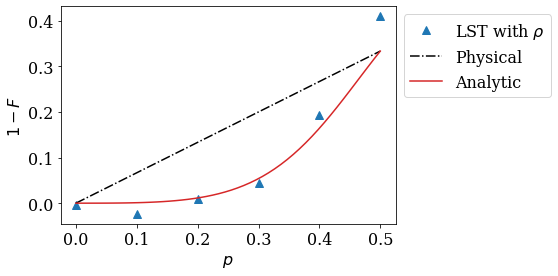

In [17]:
if use_rho:
    plt.plot(pvalues, 1.0 - lst_fidelities.real, "^", markersize=8, label=r"LST with $\rho$")

if use_rho_squared:
    plt.plot(pvalues, 1 - lst_vd_fidelities.real, "*", markersize=8, label=r"LST with $\rho^2$")


plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - analytic_fidelity(np.linspace(0, 0.5, 50)), c="C3", label="Analytic"
)

# Plot options.
plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend(bbox_to_anchor=(1, 1));